# 5. K-Means

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [193]:
dataset = pd.read_excel("/content/drive/MyDrive/DAT/6주차/Online Retail.xlsx")
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 1. 데이터전처리

#### 전처리

In [194]:
dataset = dataset[dataset['Quantity'] > 0]
dataset = dataset[dataset['UnitPrice'] > 0]
dataset = dataset[dataset['CustomerID'].notnull()]
print(dataset.shape)
dataset.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [195]:
dataset['Country'].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

In [196]:
dataset['sale_amount'] = dataset['Quantity'] * dataset['UnitPrice']
dataset['CustomerID'] = dataset['CustomerID'].astype(int)

In [197]:
aggregations = {
    'InvoiceDate': 'max',
    'InvoiceNo': 'count',
    'sale_amount':'sum'
}
cust_df = dataset.groupby('CustomerID').agg(aggregations)

In [198]:
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                    'InvoiceNo':'Frequency',
                                    'sale_amount':'Monetary'
                                   }
                        )
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12347,2011-12-07 15:52:00,182,4310.00
2,12348,2011-09-25 13:13:00,31,1797.24


In [199]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 컬럼 건수는 ',cust_df.shape)
cust_df.head(3)

cust_df 로우와 컬럼 건수는  (4338, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,3,182,4310.00
2,12348,76,31,1797.24


In [200]:
cust_df.to_csv('kmdf.csv',index=False)

In [201]:
X = cust_df.values
X

array([[1.23460e+04, 3.26000e+02, 1.00000e+00, 7.71836e+04],
       [1.23470e+04, 3.00000e+00, 1.82000e+02, 4.31000e+03],
       [1.23480e+04, 7.60000e+01, 3.10000e+01, 1.79724e+03],
       ...,
       [1.82820e+04, 8.00000e+00, 1.20000e+01, 1.78050e+02],
       [1.82830e+04, 4.00000e+00, 7.56000e+02, 2.09488e+03],
       [1.82870e+04, 4.30000e+01, 7.00000e+01, 1.83728e+03]])

### 데이터 시각화(전체 데이터 분포 확인)

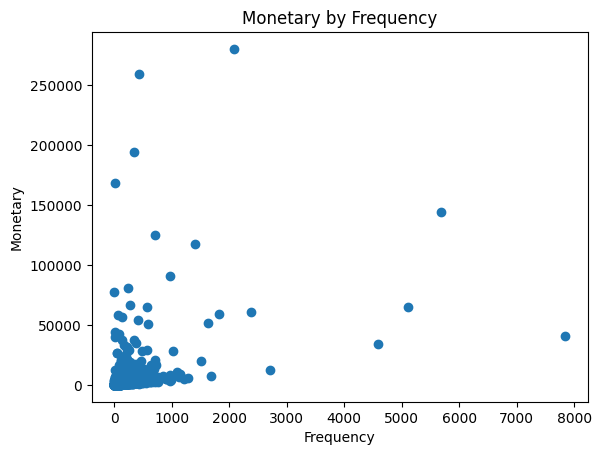

In [202]:
plt.scatter(X[:,2], X[:,3]) # x축:Frequency, y축:Monetary 
plt.title('Monetary by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

### 데이터 시각화(축 범위 통일)

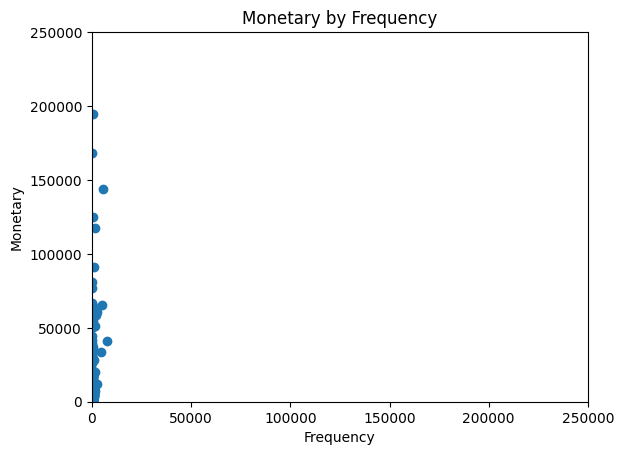

In [203]:
plt.scatter(X[:,2], X[:,3]) # x축:Frequency, y축:Monetary 
plt.title('Monetary by Frequency')
plt.xlabel('Frequency')
plt.xlim(0,250000)
plt.ylabel('Monetary')
plt.ylim(0,250000)
plt.show()

### 피처 스케일링(Feature Scaling)

In [204]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X[:5]

array([[-1.71607273,  2.32938811, -0.3965777 ,  8.35866818],
       [-1.71549188, -0.90058811,  0.39464896,  0.25096626],
       [-1.71491103, -0.17059349, -0.26543516, -0.02859601],
       [-1.71433018, -0.74058929, -0.08183561, -0.0330118 ],
       [-1.71374933,  2.17938921, -0.32663501, -0.19134727]])

#### 데이터 시각화(스케일링된 데이터)

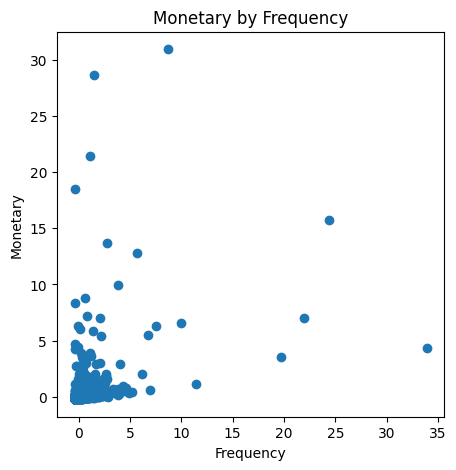

In [205]:
plt.figure(figsize=(5,5))
plt.scatter(X[:,2], X[:,3]) # x축:Frequency, y축:Monetary 
plt.title('Monetary by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

#### 최적의 K 값 찾기(엘보우 방식 Elbow Method)

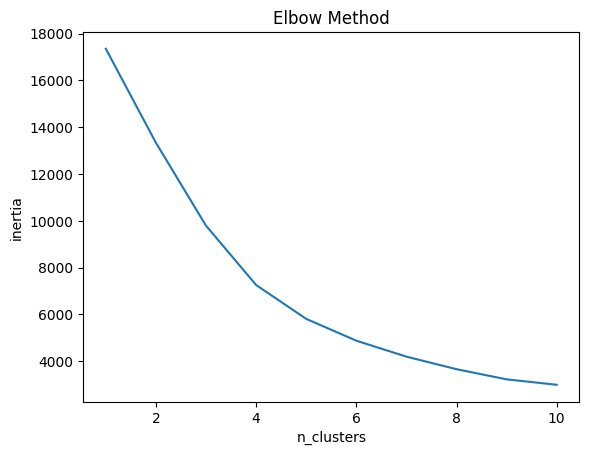

In [206]:
from sklearn.cluster import KMeans
inertia_list = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++',random_state=0)
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_)    # 각 지점으로부터 클러스터의 중심(centroid)까지의 거리의 제곱의합
plt.plot(range(1,11), inertia_list)
plt.title('Elbow Method')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.show()

#### 최적의 K(4) 값으로 KMeans 학습

In [207]:
K = 5 # 최적의 K 값

In [208]:
kmeans = KMeans(n_clusters = K, random_state=0)
#kmeans.fit(X)
y_kmeans = kmeans.fit_predict(X)

In [209]:
y_kmeans

array([4, 0, 0, ..., 1, 1, 1], dtype=int32)

#### 데이터 시각화(최적의 K)

In [210]:
centers = kmeans.cluster_centers_   # 클러스터의 중심점(centroid) 좌표
centers

array([[-8.85758083e-01, -4.74047312e-01,  5.66791600e-02,
         1.82703829e-02],
       [ 8.80769634e-01, -4.57758731e-01,  3.28914976e-02,
        -2.18096668e-02],
       [ 1.36747177e-01, -8.50588483e-01,  3.21348501e+00,
         2.10063545e+01],
       [-2.33158507e-01, -9.05588078e-01,  2.49838753e+01,
         7.66238678e+00],
       [ 2.46307602e-03,  1.65906775e+00, -2.83613472e-01,
        -1.58000894e-01]])

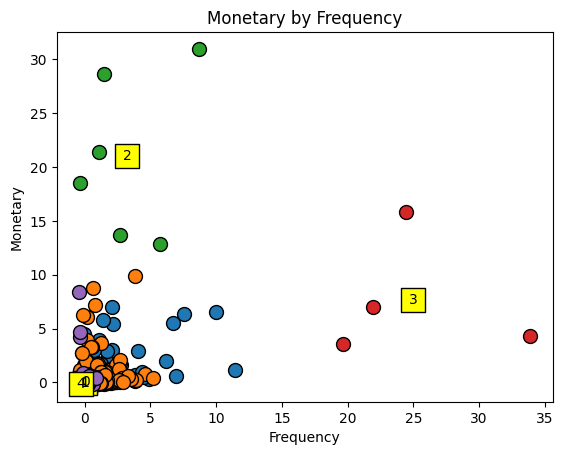

In [211]:
for cluster in range(K):
    plt.scatter(X[y_kmeans == cluster, 2], X[y_kmeans == cluster, 3], s=100, edgecolor='black')
    plt.scatter(centers[cluster,2],centers[cluster,3],s=300,edgecolor='black', color = 'yellow', marker='s')    # 중심점 네모
    plt.text(centers[cluster,2],centers[cluster,3], cluster, va='center', ha='center')     # 클러스터 텍스트 출력
plt.title('Monetary by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

#### 데이터 시각화 (스케일링 원복)

In [212]:
X_org = sc.inverse_transform(X) # Feature Scaling 된 데이터를 다시 원복
X_org[:5]

array([[1.23460e+04, 3.26000e+02, 1.00000e+00, 7.71836e+04],
       [1.23470e+04, 3.00000e+00, 1.82000e+02, 4.31000e+03],
       [1.23480e+04, 7.60000e+01, 3.10000e+01, 1.79724e+03],
       [1.23490e+04, 1.90000e+01, 7.30000e+01, 1.75755e+03],
       [1.23500e+04, 3.11000e+02, 1.70000e+01, 3.34400e+02]])

In [213]:
centers_org = sc.inverse_transform(centers)
centers_org

array([[1.37754780e+04, 4.56543943e+01, 1.04686461e+02, 2.21848421e+03],
       [1.68167499e+04, 4.72832643e+01, 9.92448255e+01, 1.85823694e+03],
       [1.55358333e+04, 8.00000000e+00, 8.26833333e+02, 1.90863462e+05],
       [1.48990000e+04, 2.50000000e+00, 5.80700000e+03, 7.09252875e+04],
       [1.53046485e+04, 2.58967471e+02, 2.68415530e+01, 6.34123726e+02]])

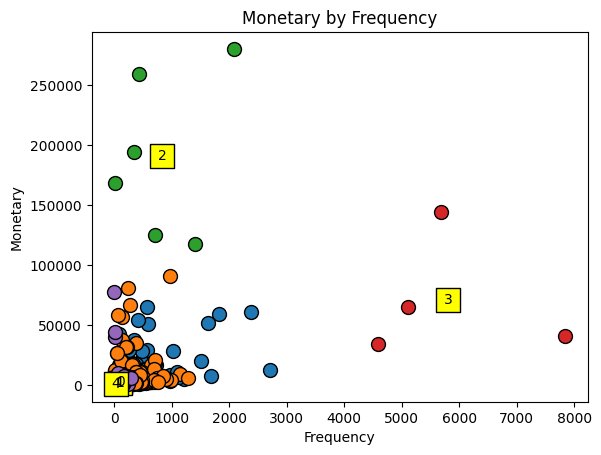

In [214]:


for cluster in range(K):
    plt.scatter(X_org[y_kmeans == cluster, 2], X_org[y_kmeans == cluster, 3], s=100, edgecolor='black')
    plt.scatter(centers_org[cluster,2],centers_org[cluster,3],s=300,edgecolor='black', color = 'yellow', marker='s')    # 중심점 네모
    plt.text(centers_org[cluster,2],centers_org[cluster,3], cluster, va='center', ha='center')     # 클러스터 텍스트 출력
plt.title('Monetary by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()